# Notes
* Is my method of testing it on iterations of new train test splits canonical or bad? 
* Is it possible to do gradient descent with an algorithm such as Levenberg-Marquart in $n$-dimensions? If so could that be applied to hyperparameter tuning, where $z(x_1, x_2,...x_n)$ is the mean loss function being optimized based on $x$ hyperparameter arrays? 
* Is there such a thing as multi-output linear regression? 
* How correlated are QPO properties with eachother? I should look into this. 
* I think I need to re do this testing scheme because re-splitting on each test could confound the results.
* Paper which seems to do similiar testing scheme: `https://arxiv.org/pdf/1903.07167.pdf` 

## Last Notes 
(before starting new notebook)

### Prediction Intervals  
*   
    * [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)
    * [Confidence Intervals for Machine Learning
](https://machinelearningmastery.com/confidence-intervals-for-machine-learning/)  
    * [A Gentle Introduction to the Bootstrap Method
](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/)
        * Will probably come back to these above links ^^ 

* I was thinking of ways to visualize the combination of confidence intervals on XSPEC returned values as well as confidence intervals on regression values, and at first I was thinking of doing something like the image below for XSPEC values and then putting errorbars on the points with the yerr argument, as shown below: 

    [<img src="https://raw.githubusercontent.com/thissop/MAXI-J1535/main/documentation/images/sphx_glr_plot_gpr_noisy_targets_001.png?token=AQN5JT7WMFM7HJ45ETNPXGLBWKYTS" width="400">](image)

    But this doesn't really work out. 

* Instead, now I think I'll just do xerr = xspec confidence intervals and yerr = confidence intervals on predicted values

### New Research Focus / Direction (?)
* I think it would be a good time to pursue a new direction with the research. Rather than continuing to scramble to get neural nets to work, what if I test multiple models (e.g. lasso regression), compare them, and discuss why the chosen final one is the best? I like this solution because it still lets me explore neural nets within the context of the paper while allowing me to produce the best model in the end (either way this is probably something I should have done to validate why I was using neural nets to begin with). 
* Possible strategy: I wonder if this would be a good application of rare class problem solutions, because (I just did a quick check) 127/185 (or ~69%) of my samples have **not a single** QPO in their power density spectrum. For example, I wonder if I could train three models: one for one qpo, one for two qpos, three for three qpos, and then use them once I've classified how many qpos there are based on the initial classification (possibly KNN) step. 

* This is more of a question for Doctor G, but I'm interested in the variability of the model prediction accuracy between each train test split -- the extreme variability is puzzling. I wonder if it has to do with not having enough data or overfitting during each iteration. 

* Good link for [Multi-Output Regression](https://machinelearningmastery.com/multi-output-regression-models-with-python/)
* I think the idea of moving away from neural networks is also good because the sample is so incredibly small. 
* Some simplier regression machine learning algorithms that support multiple outputs directly: 
    * KNNRegression (although I don't want to use KNN twice)
    * LinearRegression (an related such as RidgeRegression and LASSORegression)
    * DecisionTreeRegressor
    * RandomForestRegressor (and related)
* Another good idea is to train multiple iterations of the same model and average their predictions (I did this in my most recent version of the neural network-knn ensemble...the variance was really bad tho haha). 
* I wonder if there are outliers in the dataset ... sklearn library has a couple nice outlier detection algos (e.g. OneClassSVM, LocalOutlierFactor, IsolationForest, etc. See this [link](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py))
* The multi-output regression article I linked up above also discusses this interesting concept called **chained multi-output regression:** 
     
     * From the article: "if a multioutput regression problem required the prediction of three values y1, y2 and y3 given an input X, then this could be partitioned into three dependent single-output regression problems as follows: 1. Given X, predict y1; 2. Given X and yhat1, predict y2; 3. Given X, yhat1, and yhat2, predict y3 
        * The model example was a chained linear Support Vector Machine (SVM), but more importantly the sklearn tool [RegressorChain](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.RegressorChain.html) was used. 
        * I wonder how a chained multioutput regression model would compare to an innately multioutput model.  
         
* Not sure if this article is helpful, but here's the arXiv link: [link](https://arxiv.org/pdf/1901.00248.pdf). 
* sklearn also has this interesting feature called [sklearn.multioutput.MultiOutputRegressor
](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html) which "consists of fitting one regressor per target...a simple strategy for extending regressors that do not natively support multi-target regression." 
* **Encoding:** I also wonder if I should choose one hot encoding rather than ordinal...I feel like ordinal is okay though.
* **Train/test/validation:** It seems that using a different train test validation scheme would be good for this. 
    * From [applied predictive modeling](https://vuquangnguyen2016.files.wordpress.com/2018/03/applied-predictive-modeling-max-kuhn-kjell-johnson_1518.pdf): "As previously discussed, there is a strong technical case to be made against a single, independent test set"
        * A test set is a single evaluation of the model and has limited ability to characterize the uncertainty in the results.
        * With small sample sizes:
            * The model may need every possible data point to adequately determine model values.
            * The uncertainty of the test set can be considerably large to the point where different test sets may produce very different results.
            * Resampling methods can produce reasonable predictions of how well the model will perform on future samples.

    * From [ml master](): "They go on to make a recommendation for small sample sizes of using 10-fold cross validation in general because of the desirable low bias and variance properties of the performance estimate. " 

    * **Conclusion:** thus it seems like it would be good to do k-fold cross validation from now on. [link](https://machinelearningmastery.com/k-fold-cross-validation/) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.metrics import confusion_matrix, accuracy_score

np.set_printoptions(suppress=True)
pd.set_option("display.max_columns", None, "display.max_rows", None)

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/My Drive/Colab Outputs/Hyperparameter Tuning/file.txt', 'w') as f:
  f.write('content')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv?token=AQN5JT5QIRR27XYKMC2W25DBWKHRU')
df = df.sample(frac=1)

In [5]:
# pairplot 
pair_df = df[['hardness','tins','disk_norm','gammas','nthcomp_norms','fit_stats','red_fit_stats','count_rates','bg_ratio','intensities','num_qpos', 'red_fit_stats']]
print(pair_df)
#sns.pairplot(data=pair_df) # Not working fix this

     hardness      tins     disk_norm   gammas  nthcomp_norms  fit_stats  \
58   0.277655  0.263445  1.000000e-01  2.82244   1.385550e+02   68517.29   
30   0.344956  0.200000  1.726330e+07  2.39913   6.820780e+01     624.27   
172  0.332994  0.200003  4.938060e+05  2.29493   2.640320e-01     459.24   
173  0.314033  0.200000  5.919310e+05  2.37524   3.011160e-01     420.37   
101  0.053784  0.846341  5.573860e+02  1.18267   6.406090e-16   44215.55   
152  0.109145  0.262033  2.229490e+05  3.63045   1.118870e+00     537.43   
144  0.293193  0.200000  5.718330e+05  2.45071   2.545810e-01     373.15   
67   0.281837  0.261690  1.000000e-01  2.79862   1.412360e+02   14145.00   
116  0.035094  0.278558  1.237440e+05  3.51316   1.037920e-01     241.45   
146  0.447242  0.200000  9.406350e+04  1.91640   8.196870e-02     186.22   
157  0.311717  0.200000  5.546430e+05  2.39634   2.442250e-01     218.73   
11   0.352806  0.200000  1.665530e+07  2.33879   4.264550e+01    1063.24   
53   0.29697

               hardness      tins  disk_norm    gammas  nthcomp_norms  \
hardness       1.000000 -0.443742   0.463163 -0.711904       0.318836   
tins          -0.443742  1.000000  -0.288128 -0.057310      -0.269338   
disk_norm      0.463163 -0.288128   1.000000 -0.310087       0.146088   
gammas        -0.711904 -0.057310  -0.310087  1.000000      -0.106139   
nthcomp_norms  0.318836 -0.269338   0.146088 -0.106139       1.000000   
fit_stats     -0.161780  0.690000  -0.219948 -0.236082       0.178350   
red_fit_stats -0.176122  0.716265  -0.221830 -0.238804       0.152784   
count_rates    0.377828 -0.204159   0.295962 -0.201494       0.954837   
bg_ratio       0.211090 -0.073547  -0.011194 -0.153407       0.822034   
intensities    0.379266 -0.213661   0.285634 -0.197754       0.957324   
num_qpos       0.431717 -0.224039   0.888505 -0.261788       0.276155   

               fit_stats  red_fit_stats  count_rates  bg_ratio  intensities  \
hardness       -0.161780      -0.176122     

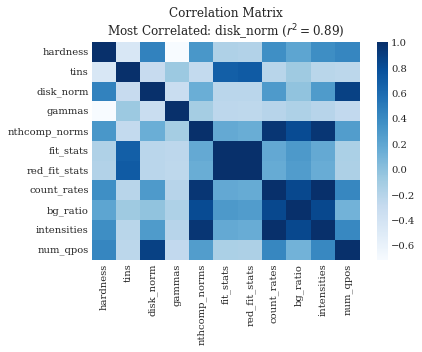

In [6]:
# Correlation matrix plot
corr_df = df[['hardness','tins','disk_norm','gammas','nthcomp_norms','fit_stats','red_fit_stats','count_rates','bg_ratio','intensities','num_qpos']].corr()

sns.heatmap(corr_df, cmap='Blues')

plt.title('Correlation Matrix\nMost Correlated: disk_norm ('+r'$r^2=$'+'0.89)')

print(corr_df)

In [7]:
# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(df[arr_name])) for arr_name in arr_names)

# Y
num_qpos = np.array(df['num_qpos']).reshape(len(df), 1)
## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6)

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

def split_data(): 
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(x_vals, num_qpos, test_size=0.1)
    return X_train, X_test, y_train, y_test

In [8]:
def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

In [9]:
ks = np.arange(1, 31, 1)
accs = np.array([])

for k in ks: 
    X_train, X_test, y_train, y_test = split_data()
    acc = knn_predict(k, X_train, np.ravel(y_train), X_test, y_test)[0]
    accs = np.append(accs, acc)

Text(0.5, 1.0, 'K vs Accuracy\nMost Accurate: k=1-3; acc=0.84')

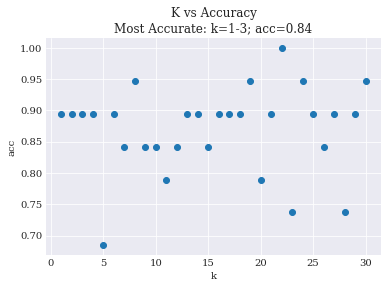

In [10]:
# k vs acc plot
plt.scatter(ks, accs)
plt.xlabel('k')
plt.ylabel('acc')
plt.title('K vs Accuracy\nMost Accurate: k=1-3; acc=0.84')

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


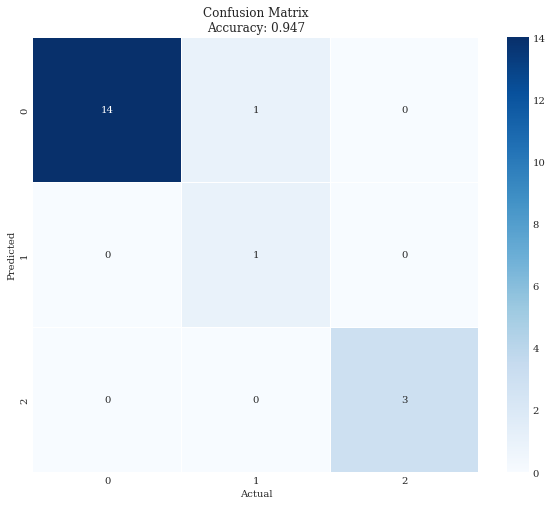

In [11]:
# k=3 confusion matrix
y_test = y_test.flatten()

acc, predictions = knn_predict(7, X_train, y_train, X_test, y_test)

predictions = predictions.flatten()

fig, ax = plt.subplots(figsize=(10, 8))
plt.rcParams['font.family']='serif'

cm = confusion_matrix(y_test.flatten(), predictions)

sns.heatmap(cm, annot=True, cmap='Blues', linewidths=.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')

plt.title('Confusion Matrix\nAccuracy: '+str(round(acc, 3)))
plt.show()

## K tuning

In [12]:
ks = np.arange(1, 9, 1)
accs = np.array([], dtype=np.float32).reshape(0, 100)

for k_idx, k in enumerate(ks): 
    current_accs = np.array([])
    for i in range(100): 
        X_train, X_test, y_train, y_test = split_data()
        acc = knn_predict(k, X_train, np.ravel(y_train), X_test, y_test)[0]
        current_accs = np.append(current_accs, acc)

    accs = np.vstack((accs, current_accs))

In [13]:
for k, acc_row in zip(ks, accs): 
    print(k, np.mean(acc_row), np.std(acc_row))

1 0.8905263157894737 0.06475181683886189
2 0.9236842105263158 0.05783489730483134
3 0.9126315789473683 0.06147764947557406
4 0.8963157894736841 0.07156927179187969
5 0.8989473684210526 0.06560183768792793
6 0.9184210526315789 0.06109571982233631
7 0.9042105263157894 0.06547503806351151
8 0.9152631578947369 0.055647784324957705


## Parameter Searching

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from keras import models, layers
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, median_absolute_error
from scipy.stats import linregress
from google.colab import files

np.set_printoptions(suppress=True)

In [16]:
combined_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv?token=AQN5JT5QIRR27XYKMC2W25DBWKHRU')

combined_df = combined_df.sample(frac=1) # shuffle the dataframe

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(combined_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(combined_df['num_qpos']).reshape(len(combined_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(combined_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

In [17]:
def split_data(x_vals, y_vals, num_qpos): 
        # Train test split
        X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.05)
        return X_train, X_test, y_train, y_test, qpo_train, qpo_test
        
def get_model(num_neurons, num_layers, lr): 
    model = models.Sequential()
    
    model.add(layers.Dense(num_neurons, activation='relu')) 

    if num_layers == 2: 
        model.add(layers.Dense(num_neurons, activation='relu')) 
    
    model.add(layers.Dense(3, activation='linear'))
    opt = tf.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics='mae')
    return model

def early_stop_model(num_neurons, num_layers, lr, patience_val): 

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience_val, verbose=0, mode='auto', restore_best_weights=True)
    model = models.Sequential()
    
    model.add(layers.Dense(num_neurons, activation='relu')) 

    if num_layers == 2: 
        model.add(layers.Dense(num_neurons, activation='relu')) 
    
    model.add(layers.Dense(3, activation='linear'))
    opt = tf.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse', metrics='mae')
    
    return model


def knn_predict(k, xtrain, ytrain, xtest): 
        knn = KNeighborsClassifier(k)
        knn.fit(xtrain, ytrain)
        predictions = knn.predict(xtest)
        return predictions

def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

def run_model(x_vals, y_vals, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr): 
    
    mse_arr = np.array([])
    mae_arr = np.array([])

    for i in range(3): 

        X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

        reg_model = get_model(num_neurons, num_layers, lr)
        history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
        
        
        regress_predictions = reg_model.predict(X_test) 
        class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
        predictions = cullBuffers(regress_predictions, class_predictions)

        flat_y_test = y_test.flatten()
        flat_y_pred = predictions.flatten()


        mse = mean_squared_error(flat_y_test, flat_y_pred)
        mae = median_absolute_error(flat_y_test, flat_y_pred)

        mse_arr = np.append(mse_arr, mse)
        mae_arr = np.append(mae_arr, mae)


    return np.mean(mse_arr), np.mean(mae_arr)

def run_earlystop_test(x_vals, y_vals, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr):
    mse_arr = np.array([])
    mae_arr = np.array([])

    for i in range(2): 

        X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

        reg_model = early_stop_model(num_neurons, num_layers, lr, 50)
        history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
        
        regress_predictions = reg_model.predict(X_test) 
        class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
        predictions = cullBuffers(regress_predictions, class_predictions)

        flat_y_test = y_test.flatten()
        flat_y_pred = predictions.flatten()

        mse = mean_squared_error(flat_y_test, flat_y_pred)
        mae = median_absolute_error(flat_y_test, flat_y_pred)

        mse_arr = np.append(mse_arr, mse)
        mae_arr = np.append(mae_arr, mae)

    return np.mean(mse_arr), np.mean(mae_arr)

def run_earlystop(x_vals, y_vals, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr):
    
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

    reg_model = early_stop_model(num_neurons, num_layers, lr, 50)
    history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
    
    regress_predictions = reg_model.predict(X_test) 
    class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
    predictions = cullBuffers(regress_predictions, class_predictions)

    flat_y_test = y_test.flatten()
    flat_y_pred = predictions.flatten()

    mse = mean_squared_error(flat_y_test, flat_y_pred)
    mae = median_absolute_error(flat_y_test, flat_y_pred)


    return mse, mae, flat_y_test, flat_y_pred, history


In [ ]:
batch_sizes = [4, 8, 16, 32]
learning_rates = [0.1, 0.01, 0.001] 
layer_nums = [1, 2] 
layer_neurons = [4, 8, 12, 16]

In [ ]:
permutations = np.array([]).reshape(0, 4)

for bs in batch_sizes:
    for lr in learning_rates: 
        for ln in layer_nums: 
            for lneu in layer_neurons: 
                row = np.array([bs, lr, ln, lneu])
                permutations = np.vstack((permutations, row))

np.random.shuffle(permutations)

## Early Stopping

In [ ]:
patience_values = np.array([5, 10, 20, 50, 100, 200])
total_epochs = np.array([])

def early_stop_test(x_vals, y_vals, num_qpos, patience_value): 
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience_value, restore_best_weights=True) 
    
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

    reg_model = early_stop_model(8, 1, 0.001, patience_value)
    history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=4000, batch_size=4, verbose=0, callbacks=[callback])

    num_epochs = len(history.history['loss'])        
    
    return num_epochs

for pv in patience_values: 
    numepochs = early_stop_test(x_vals, y_vals, num_qpos, pv)
    total_epochs = np.append(total_epochs, numepochs)

KeyboardInterrupt: ignored

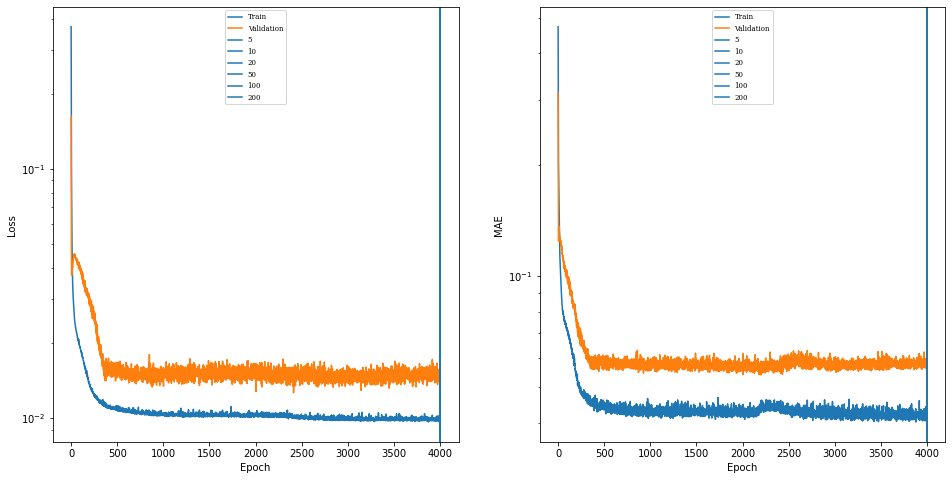

In [ ]:
model = get_model(8,1,0.001)
X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 
history = model.fit(X_train, y_train, validation_split = 0.1, epochs=4000, batch_size=4, verbose=0)

[ 222.  390.  408. 1186. 1501.  937.]


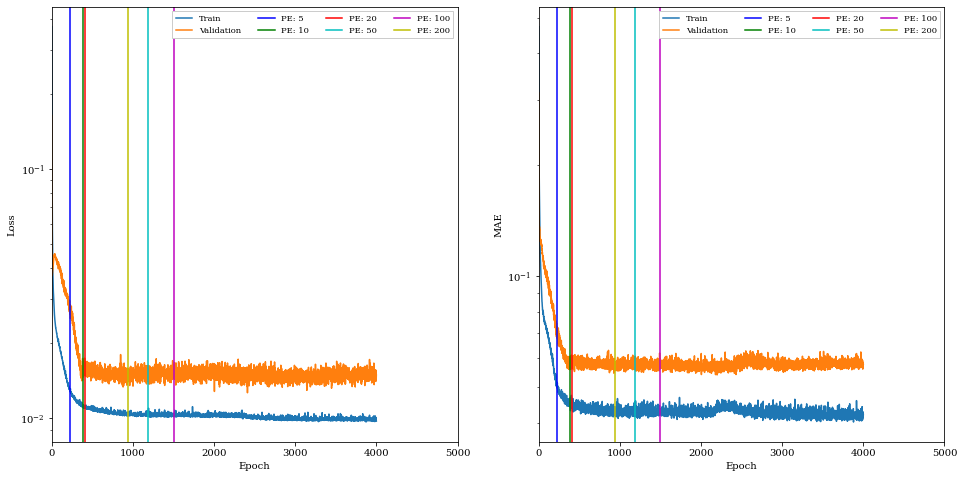

In [ ]:

# PLOT IT
hist = history.history
epochs_arr = np.array(range(1, 4000+1))

train_loss = hist['loss']
val_loss = hist['val_loss']

train_mae = hist['mae']
val_mae = hist['val_mae']

# Make plot

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plt.rcParams['font.family']='serif'

axs[0].plot(epochs_arr, train_loss, label='Train')
axs[0].plot(epochs_arr, val_loss, label='Validation')
        
axs[0].set(xlabel='Epoch', ylabel='Loss')

axs[1].plot(epochs_arr, train_mae, label='Train')
axs[1].plot(epochs_arr, val_mae, label='Validation')
axs[1].set(xlabel='Epoch', ylabel='MAE')


print(total_epochs)

for counter, (es, pv) in enumerate(zip(total_epochs, patience_values)):
    for ax in [axs[0], axs[1]]:
        ax.axvline(es, label='PE: '+str(pv), color=colors[counter])

for ax in (axs[0], axs[1]):
    ax.set(yscale='log')
    ax.legend(fontsize='small', ncol=4, framealpha=1, fancybox=False)
    ax.set(xlim=(0, 5000))

plt.show()

## Actual Parameter Search 
* Going to set ```patience``` to ```50```
* use Successive Halving Iterations in hyperparameter tuning?
* Currently using simple hold-out validation, should I use k-fold or iterated k-fold (later is for situations in which one has relatively little data available)  

In [ ]:
for arr_index, sub_arr in enumerate(np.split(permutations, 32)):
    evaluations = np.array([]).reshape(0,6)
    for row in sub_arr: 
        mse, mae = run_earlystop_test(x_vals, y_vals, num_qpos, 5000, int(row[0]), int(row[3]), int(row[2]), row[1]) # fix
        row = np.concatenate(([mse, mae], row)) # fix
        evaluations = np.vstack([evaluations, row])
    
    sub_results_df = pd.DataFrame(evaluations, columns=['mse', 'mae', 'batch_size', 'learning_rate', 'layer_number', 'neuron_number'])
    filename = '/content/gdrive/My Drive/Colab Outputs/Hyperparameter Tuning/'+'sub_arr_results('+str(arr_index)+').csv'
    sub_results_df.to_csv(filename, index=False)
    #files.download(filename)

In [ ]:
# test one of the best versions
mse, mae, y_test_flat, y_pred_flat = run_earlystop(x_vals, y_vals, num_qpos, 5000, 32, 4, 2, 0.01)

KeyboardInterrupt: ignored

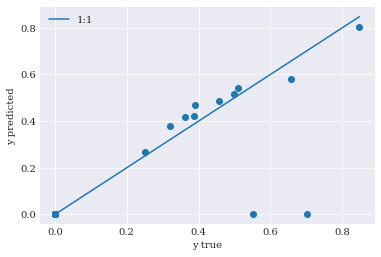

In [ ]:
x_line = np.linspace(min(y_test_flat), max(y_test_flat), 3)

plt.scatter(y_test_flat, y_pred_flat)
plt.plot(x_line, x_line, label='1:1')
plt.xlabel('y true')
plt.ylabel('y predicted')
plt.legend()

plt.show()

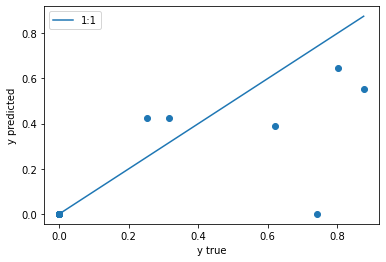

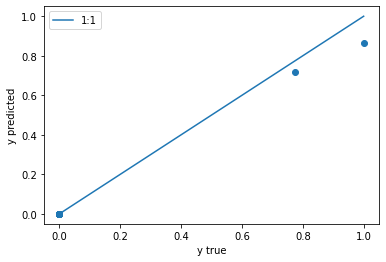

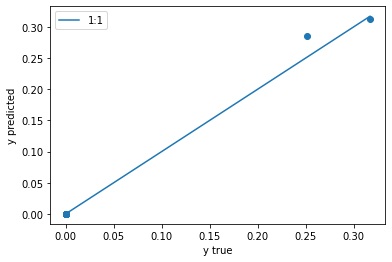

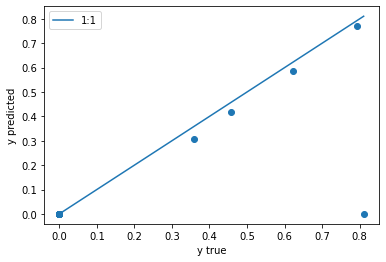

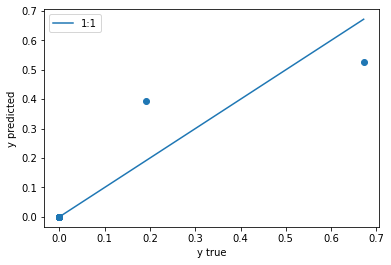

In [ ]:
for i in range(5):
    mse, mae, y_test_flat, y_pred_flat, hist = run_earlystop(x_vals, y_vals, num_qpos, 5000, 32, 4, 2, 0.01)
    
    x_line = np.linspace(min(y_test_flat), max(y_test_flat), 3)
    plt.scatter(y_test_flat, y_pred_flat)
    plt.plot(x_line, x_line, label='1:1')
    plt.xlabel('y true')
    plt.ylabel('y predicted')
    plt.legend()

    plt.show()

In [ ]:
while True:pass

## QPO Parameter Correlations


In [ ]:
merged_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

In [ ]:
freqs = np.concatenate((merged_df['first_par1s'], merged_df['second_par1s'], merged_df['third_par1s']))
widths = np.concatenate((merged_df['first_par2s'], merged_df['second_par2s'], merged_df['third_par2s']))
norms = np.concatenate((merged_df['first_norms'], merged_df['second_norms'], merged_df['third_norms']))

df = pd.DataFrame(list(zip(freqs, widths, norms)), columns=['freq', 'width', 'norm'])

df = df.loc[(df!=0).any(axis=1)]

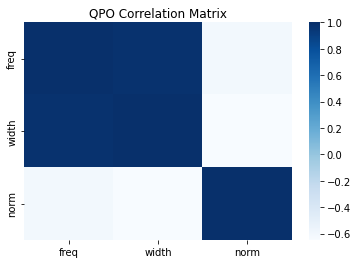

In [ ]:
# Correlation matrix plot
sns.heatmap(df.corr(), cmap='Blues')

plt.title('QPO Correlation Matrix')
plt.show()

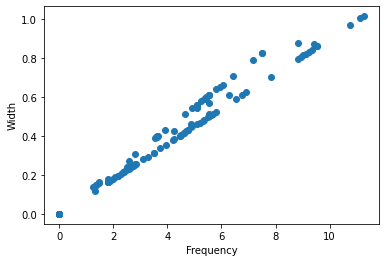

In [ ]:
plt.scatter(freqs, widths)
plt.xlabel('Frequency')
plt.ylabel('Width')
plt.show()

## Quick FWHM Test

In [ ]:
combined_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv')

combined_df = combined_df.sample(frac=1) # shuffle the dataframe

def normalize(x):
    x = (x-min(x))/(max(x)-min(x))
    return x

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(combined_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(combined_df['num_qpos']).reshape(len(combined_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

width1s, width2s, width3s = (normalize(np.array(combined_df[arr_name])) for arr_name in ['first_par2s', 'second_par2s', 'third_par2s'])

for width1, width2, width3 in zip(width1s, width2s, width3s): 
    new_arr = np.array([float(width1), float(width2), float(width3)])
    y_vals = np.vstack([y_vals, new_arr])

In [ ]:
mse, mae, y_test_flat, y_pred_flat, history = run_earlystop(x_vals, y_vals, num_qpos, 5000, 32, 4, 2, 0.01)

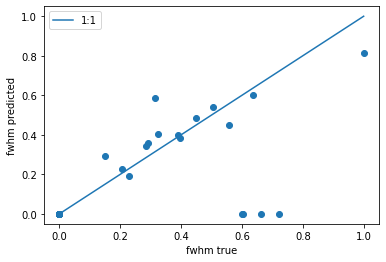

In [ ]:
x_line = np.linspace(min(y_test_flat), max(y_test_flat), 3)

plt.scatter(y_test_flat, y_pred_flat)
plt.plot(x_line, x_line, label='1:1')
plt.xlabel('fwhm true')
plt.ylabel('fwhm predicted')
plt.legend()

plt.show()

## Confidence Intervals
* **Gaussian Prediction Interval**  
    * "Involves fitting multiple final models (e.g. 10 to 30). The distribution of the point predictions from ensemble members is then used to calculate both a point prediction and a prediction interval. For example, a point prediction can be taken as the mean of the point predictions from ensemble members, and a 95% prediction interval can be taken as 1.96 standard deviations from the mean." - [ml mastery](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)


In [20]:
def run_gpi(X_train, X_test, y_train, y_test, num_qpos, num_epochs, minibatch_size, num_neurons, num_layers, lr):
    reg_model = early_stop_model(num_neurons, num_layers, lr, 50)
    history = reg_model.fit(X_train, y_train, validation_split = 0.1, epochs=num_epochs, batch_size=minibatch_size, verbose=0)
    
    regress_predictions = reg_model.predict(X_test) 
    class_predictions = knn_predict(2, X_train, np.ravel(qpo_train), X_test)
    predictions = cullBuffers(regress_predictions, class_predictions)

    flat_y_test = y_test.flatten()
    flat_y_pred = predictions.flatten()

    mse = mean_squared_error(flat_y_test, flat_y_pred)
    mae = median_absolute_error(flat_y_test, flat_y_pred)

    return mse, mae, flat_y_pred

### Gaussian Prediction Interval Test

In [27]:
X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 


ci_df = pd.DataFrame(y_test.flatten(), columns=['y_true'])

for i in range(10): 
    mse, mae, predicted = run_gpi(X_train, X_test, y_train, y_test, num_qpos, 5000, 32, 4, 2, 0.01)
    col_name = 'iteration_'+str(i)
    ci_df[col_name] = predicted

In [29]:
ci_df

,y_true,iteration_0,iteration_1,iteration_2,iteration_3,iteration_4,iteration_5,iteration_6,iteration_7,iteration_8,iteration_9
0,0.642813,0.325455,0.525863,0.620180,0.371833,0.610881,0.646061,0.532524,0.518258,0.572351,0.604216
1,0.819665,0.401568,0.794526,0.732011,0.520256,0.813683,0.749234,0.723193,0.806127,0.692391,0.790527
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


[0.28704369 0.37124006 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.11188737 0.43542812 0.        ]


[(0.0, 1.0), Text(0, 0.5, 'Predicted'), (0.0, 1.0), Text(0.5, 0, 'True')]

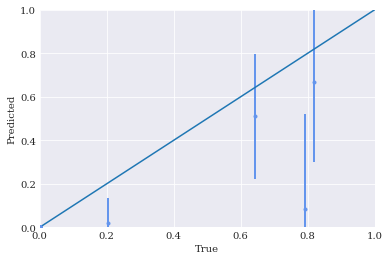

In [74]:
ci_df['mean'] = ci_df.mean(axis=1)
ci_df['deviations'] = ci_df.std(axis=1)
deviations = 1.96*np.array(ci_df['deviations'])
print(deviations)

fig, ax = plt.subplots()
ax.errorbar(y_test.flatten(), np.array(ci_df['mean']), yerr=deviations,
            ms=3, lw=0, color='cornflowerblue', marker='o', 
            elinewidth=2)

ax.plot([0,1],[0,1])

ax.set(xlim=(0,1), ylim=(0,1), xlabel='True', ylabel='Predicted')

### GPI Test Multiple Train-Test Splits

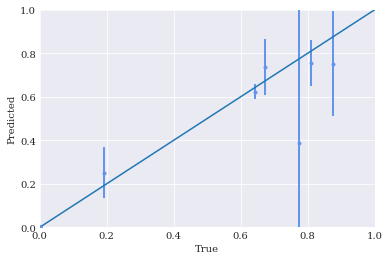

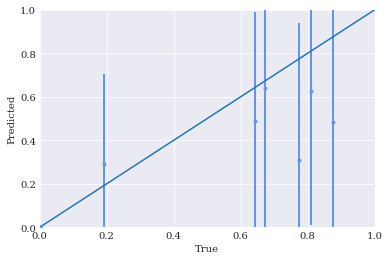

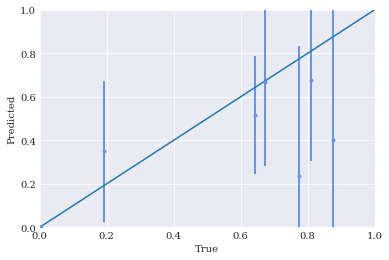

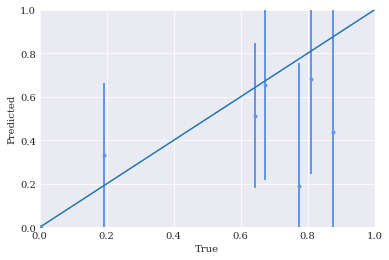

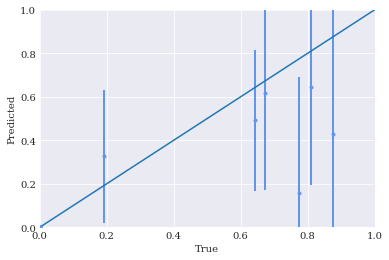

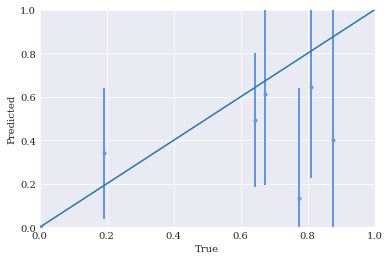

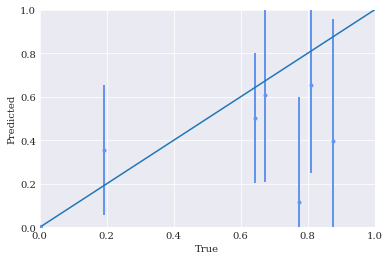

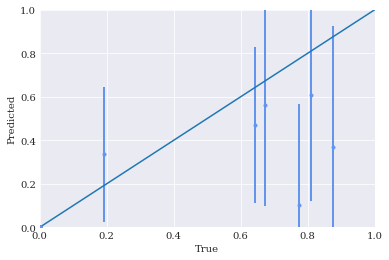

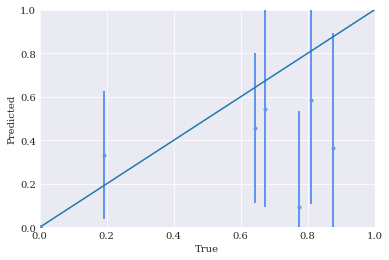

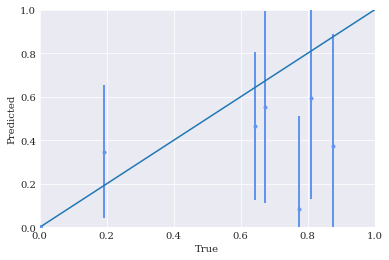

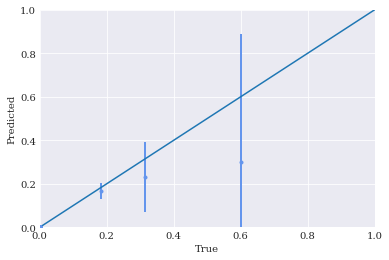

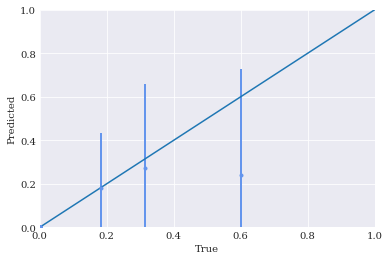

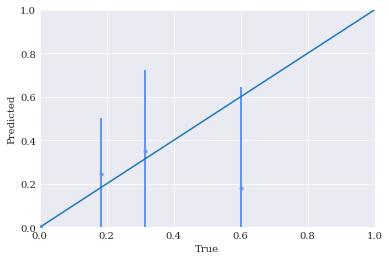

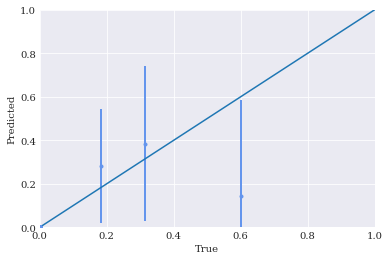

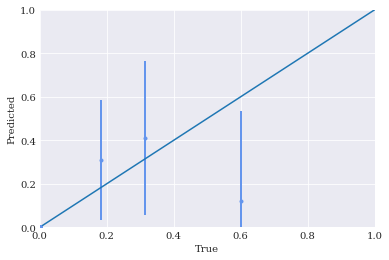

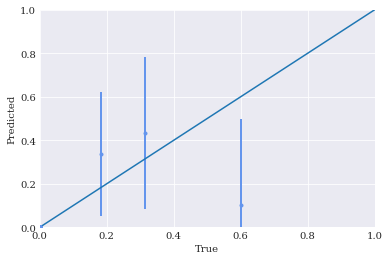

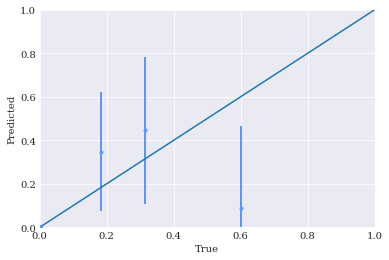

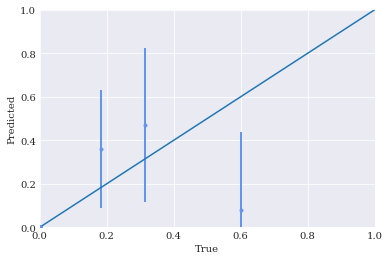

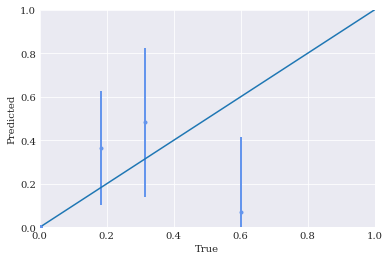

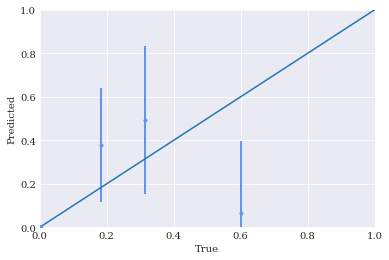

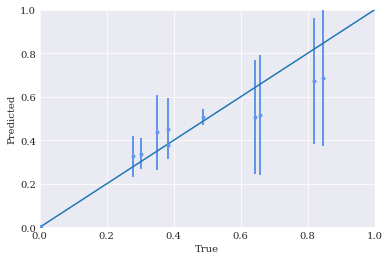

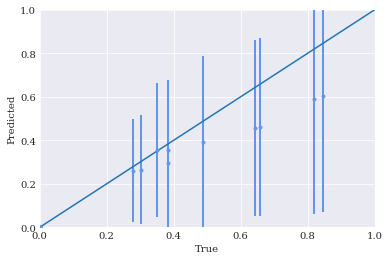

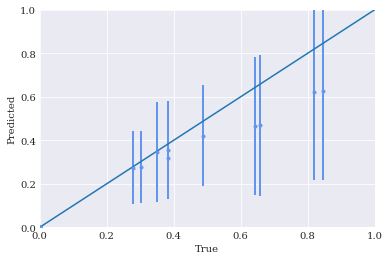

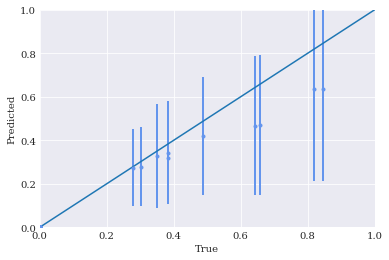

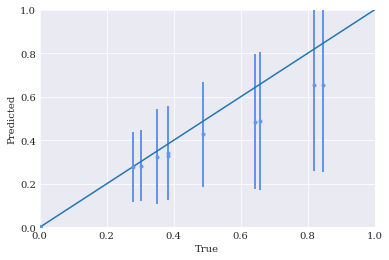

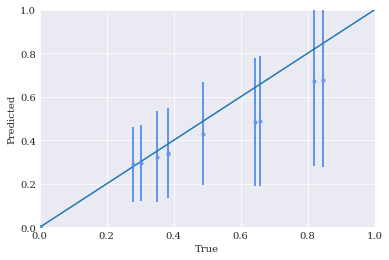

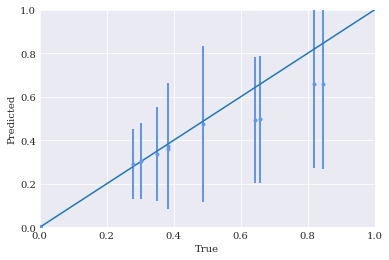

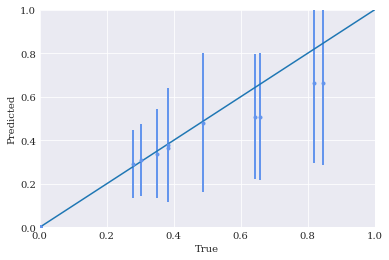

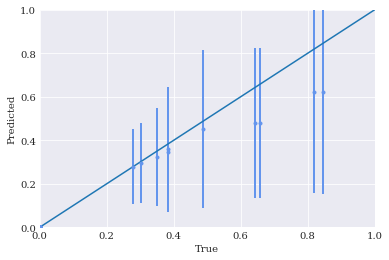

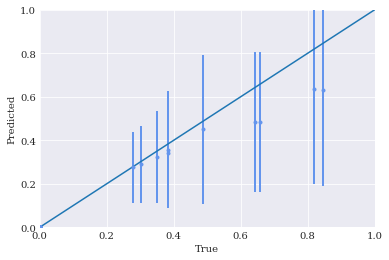

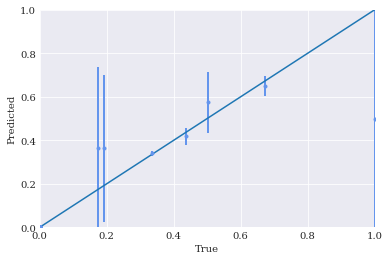

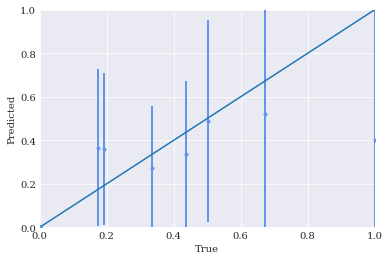

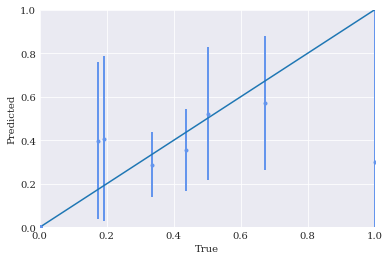

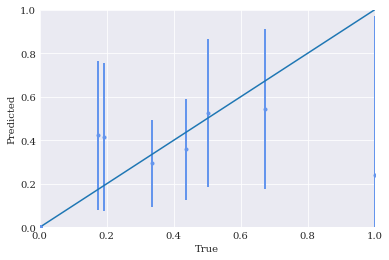

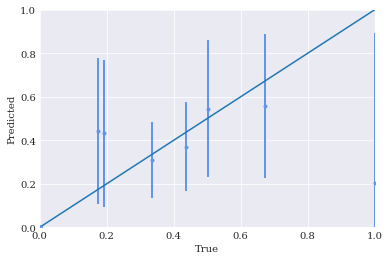

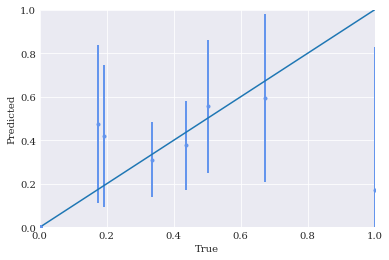

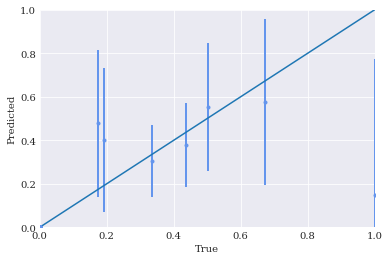

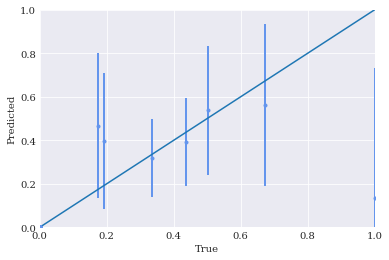

KeyboardInterrupt: ignored

In [75]:
for i in range(5): 
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 


    ci_df = pd.DataFrame(y_test.flatten(), columns=['y_true'])

    for i in range(10): 
        mse, mae, predicted = run_gpi(X_train, X_test, y_train, y_test, num_qpos, 5000, 32, 4, 2, 0.01)
        
        col_name = 'iteration_'+str(i)

        ci_df[col_name] = predicted
        ci_df['mean'] = ci_df.mean(axis=1)
        ci_df['deviations'] = ci_df.std(axis=1)
        deviations = 1.96*np.array(ci_df['deviations'])
        
        # Make Plot
        fig, ax = plt.subplots()
        ax.errorbar(y_test.flatten(), np.array(ci_df['mean']), yerr=deviations,
                    ms=3, lw=0, color='cornflowerblue', marker='o', 
                    elinewidth=2)

        ax.plot([0,1],[0,1])

        ax.set(xlim=(0,1), ylim=(0,1), xlabel='True', ylabel='Predicted')

        plt.show()
        plt.clf()
        plt.close()
